In [1]:
# can't reproduce the pandora resolution plots for electrons

import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/eos/home-g/gkrzmanc/mlpf_data")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep


hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)
import os

In [2]:
# This block is the same as 1_dataset.ipynb

datasets = {
    "train": os.listdir("/eos/experiment/fcc/ee/datasets/mlpf/CLD/train/250124")
   # "test": "/eos/home-g/gkrzmanc/testing_ds_29082023.root"
}

def remove_from_list(lst):
    out = []
    for item in lst:
        if item in ["hgcal", "data.txt", "test_file.root"] or "test" in item:
            continue
        out.append(item)
    return out

datasets["train"] = [os.path.join("/eos/experiment/fcc/ee/datasets/mlpf/CLD/train/250124", x) for x in remove_from_list(datasets["train"])]
datasets["train"] = datasets["train"][:2]
class Args:
    def __init__(self, datasets):
        self.data_train = datasets
        self.data_val = datasets
        #self.data_train = files_train
        self.data_config = '/afs/cern.ch/work/g/gkrzmanc/mlpf_2024/config_files/config_hit_tracks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = {key: Args(value) for key, value in datasets.items()}
print(args["train"].data_train)
#args["train"].data_train = args["train"].data_train[:2]
datas = {}
files_dict = {}
for key in datasets:
    train_range = (0, args[key].train_val_split)
    train_file_dict, train_files = to_filelist(args[key], 'train')
    train_data = SimpleIterDataset(train_file_dict, args[key].data_config, for_training=True,
                                   extra_selection=args[key].extra_selection,
                                   remake_weights=True,
                                   load_range_and_fraction=(train_range, args[key].data_fraction),
                                   file_fraction=args[key].file_fraction,
                                   fetch_by_files=args[key].fetch_by_files,
                                   fetch_step=args[key].fetch_step,
                                   infinity_mode=False,
                                   in_memory=args[key].in_memory,
                                   async_load=False,
                                   name='train')
    datas[key] = train_data
    files_dict[key] = train_files

['/eos/experiment/fcc/ee/datasets/mlpf/CLD/train/250124/pf_tree_1.root', '/eos/experiment/fcc/ee/datasets/mlpf/CLD/train/250124/pf_tree_10.root']
['/eos/experiment/fcc/ee/datasets/mlpf/CLD/train/250124/pf_tree_1.root', '/eos/experiment/fcc/ee/datasets/mlpf/CLD/train/250124/pf_tree_10.root']


In [3]:
y

NameError: name 'y' is not defined

In [4]:
iterators = {key: iter(val) for key, val in datas.items()}

from src.dataset.functions_graph import graph_batch_func

train_loaders = {key: DataLoader(datas[key], batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args[key].num_workers, int(len(files_dict[key]) * args[key].file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args[key].num_workers > 0 and args[key].steps_per_epoch is not None) for key in args}

iterators = {key: iter(item) for key,item in train_loaders.items()}

=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===


In [16]:
from torch_scatter import scatter_sum

def get_energy(g, y, corr_w_mass=False, return_pid_dict=False):
    part_idx = g.ndata["particle_number"]
    true_idx = np.arange(len(part_idx))
    part_idx = part_idx[true_idx]
    hit_energies = g.ndata["e_hits"].flatten()[true_idx]  #[hit_idx]
    hit_momenta = g.ndata["p_hits"].flatten()[true_idx]#[track_idx]
    y_pid = y[:, 6]
    num_tracks = scatter_sum(torch.ones_like(hit_energies) * (hit_momenta != 0), part_idx.long(), dim=0)
    y_energy = y[:, 3]
    filter = (num_tracks[1:] == 1) & (y_pid == 11)
    energy_from_tracks = scatter_sum(hit_momenta, part_idx.long(), dim=0)
    return energy_from_tracks[1:][filter], y_energy[filter]



In [17]:
def upd_dict(d, small_dict):
    for k in small_dict:
        if k not in d:
            d[k] = []
        d[k] += small_dict[k]
    return d

etracks, yenergy = [], []

for i in tqdm(range(5000)):
    for key in iterators:
        g, y = next(iterators[key])
        energy_from_tracks, y_energy = get_energy(g, y)
        etracks += (energy_from_tracks.numpy().tolist())
        yenergy += (y_energy.numpy().tolist())


  3%|▎         | 130/5000 [01:17<48:19,  1.68it/s]  


StopIteration: 

In [18]:
etracks = torch.tensor(etracks)

In [19]:
yenergy = torch.tensor(yenergy)

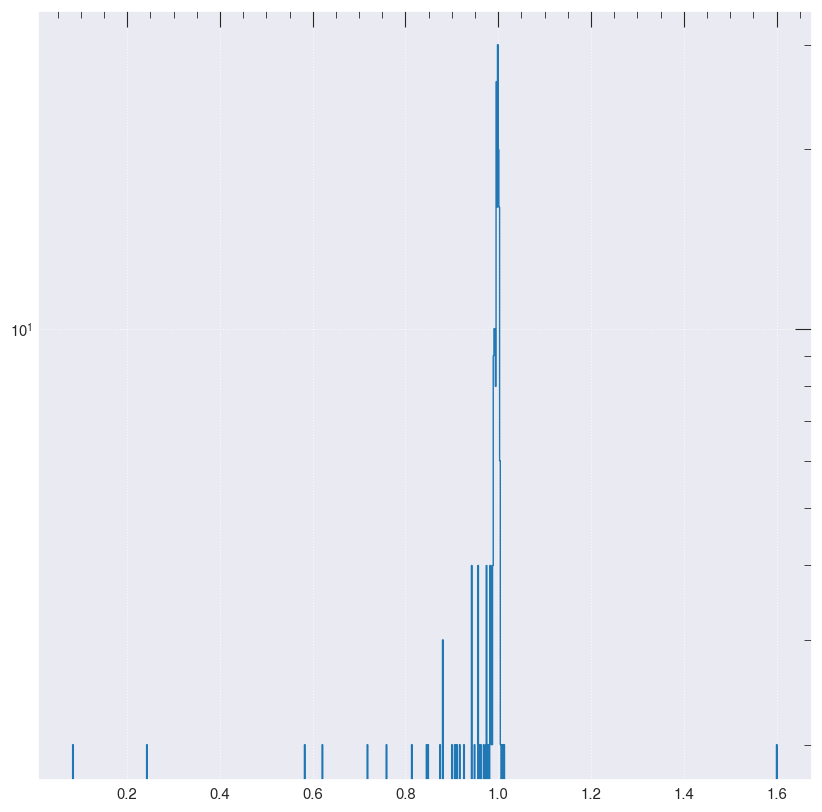

In [23]:
fig, ax = plt.subplots()
ax.hist(etracks / yenergy, bins=1000, histtype="step", label="tracks")
#ax.hist(yenergy, bins=100, range=(0, 100), histtype="step", label="pandora")
ax.set_yscale("log")
fig.show()

In [ ]:
ranges = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54]


def get_std68(theHist, bin_edges, percentage=0.683, epsilon=0.01):
    # theHist, bin_edges = np.histogram(data_for_hist, bins=bins, density=True)
    wmin = 0.2
    wmax = 1.0

    weight = 0.0
    points = []
    sums = []

    # fill list of bin centers and the integral up to those point
    for i in range(len(bin_edges) - 1):
        weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
        points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
        sums.append(weight)
    low = wmin
    high = wmax
    width = 100
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            if abs(wy - percentage) < epsilon:
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    width = wx

    return 0.5 * (high - low), low, high


def obtain_MPV_and_68_raw(data_for_hist, bins_per_binned_E=np.arange(0, 2, 1e-3), epsilon=0.01):
    hist, bin_edges = np.histogram(data_for_hist, bins=bins_per_binned_E, density=True)
    ind_max_hist = np.argmax(hist)
    #MPV = (bin_edges[ind_max_hist] + bin_edges[ind_max_hist + 1]) / 2
    std68, low, high = get_std68(hist, bin_edges, epsilon=epsilon)
    return std68

sigmaE_over_E = []
E = []

for i in range(len(ranges) - 1):
    filter = (yenergy > ranges[i]) & (yenergy < ranges[i + 1])
    sigmaE_over_E.append(obtain_MPV_and_68_raw(etracks[filter], bins_per_binned_E=np.arange(0, 2, 1e-3)))
    E.append((ranges[i] + ranges[i + 1]) / 2)
    